# Ejercicio adicional de fin de semana: semana 2

Ahora usa todo lo que aprendiste en la semana 2 para construir un prototipo completo para la pregunta/respuesta técnica que creaste en el ejercicio de la semana 1.

Esto debería incluir una interfaz de usuario de Gradio, transmisión, uso del mensaje del sistema para agregar experiencia y la capacidad de cambiar entre modelos. ¡Puntos extra si puedes demostrar el uso de una herramienta!

Si te sientes audaz, ve si puedes agregar una entrada de audio para poder hablarle y hacer que responda con audio. ChatGPT o Claude pueden ayudarte, o envíame un correo electrónico si tienes preguntas.

Pronto publicaré una solución completa aquí, a menos que alguien se me adelante...

Hay tantas aplicaciones comerciales para esto, desde un tutor de idiomas hasta una solución de incorporación de empresas, pasando por una IA complementaria para un curso (¡como este!). No puedo esperar a ver tus resultados.

In [11]:
# LIBRERIAS
import os # Libreria para acceder a variables de sistema. Ej: APIS
from dotenv import load_dotenv # Cargar variables de entorno
from openai import OpenAI # Funciones para llamar a los modelos de Open AI
import gradio as gr # Libreria para interfaz de Agentización
import re # Libreria manejo de texto
import requests # libreria para conectarse a servicios web, recursos, o enviar/recibir datos de otras aplicaciones

In [12]:
# Cargar variables de entorno en un archivo llamado .env
# Imprimir los prefijos de clave para facilitar la depuración
# Verificar que las APIS funcionan correctamente
load_dotenv()
openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key existe y empieza por {openai_api_key[:8]}")
else:
    print("OpenAI API Key Sin Configurar")

OpenAI API Key existe y empieza por sk-proj-


In [13]:
# Conectarse a APIS de OpenAI
openai = OpenAI()

In [14]:
# Definir prompt de sistema
def system_message():
    return "Necesito que actúes como un programador experto en Python. Responde lo más detallado posible, dando ejemplos. Responde en formato markdown."

In [16]:
# Definir chat de la herramienta:
# Se opta por crear un herramienta que permita seleccionar entre dos modelos cerrados y una abierto como LLaMA3.2

def chat(history, model_name):
    messages = [{"role": "system", "content": system_message()}] + history
    # Si selecciona modelo de open AI en cerrado
    if model_name == "gpt-4o":
        response = openai.chat.completions.create(model="gpt-4o", messages=messages)
        reply = response.choices[0].message.content
    # Si se selecciona modelo Llama3.2 en abierto y en local    
    elif model_name == "LLaMA3.2":
        OLLAMA_API = "http://localhost:11434/api/chat"
        MODEL_LLAMA = "llama3.2"
        HEADERS = {"Content-Type": "application/json"}
        payload = {
            "model": MODEL_LLAMA,
            "messages": messages,
            "stream": False
        }
        try:
            response = requests.post(OLLAMA_API, json=payload, headers=HEADERS)
            response_json = response.json()
            reply = response_json.get('message', {}).get('content', '[LLaMA3.2 no respondió]')
        except Exception as e:
            reply = f"[Error al conectar con LLaMA3.2: {str(e)}]"

    else:
        reply = f"[Modelo '{model_name}' no soportado.]"

    history += [{"role": "assistant", "content": reply}] # Actualizar contenido de la historia de la conversación

    # Extraer bloques de código python para llevarlo a otro recuadro en gradio estilo canvas
    code_blocks = re.findall(r"```(?:python)?(.*?)```", reply, re.DOTALL)
    canvas_code = "".join(code_blocks) if code_blocks else ""

    return history, canvas_code

In [20]:
# Interfaz Gradio
with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, label="Asistente de Código Python", type="messages")
        canvas = gr.Code(label="Bloques de código detectados", language="python", lines=20) # Cuadro solo de código
    with gr.Row():
        entry = gr.Textbox(label="Chatea con el Agente de IA:") # Selección de modelo con el cual interactuar
        model_selector = gr.Dropdown(choices=["gpt-4o","LLaMA3.2"], value="gpt-4o", label="Selecciona el modelo")
    with gr.Row():
        clear = gr.Button("Limpiar chat")
        
    def on_user_submit(message, history, model_name):
        history += [{"role": "user", "content": message}]
        updated_history, canvas_code = chat(history, model_name)
        return "", updated_history, canvas_code # Función util para actualizar el historial de la conversación y darle contexto.

    entry.submit(
        on_user_submit,
        inputs=[entry, chatbot, model_selector],
        outputs=[entry, chatbot, canvas]
    ) # Parametros de entrada en la herramienta para que empiece a trabajar.
    clear.click(lambda: [], inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7866

To create a public link, set `share=True` in `launch()`.


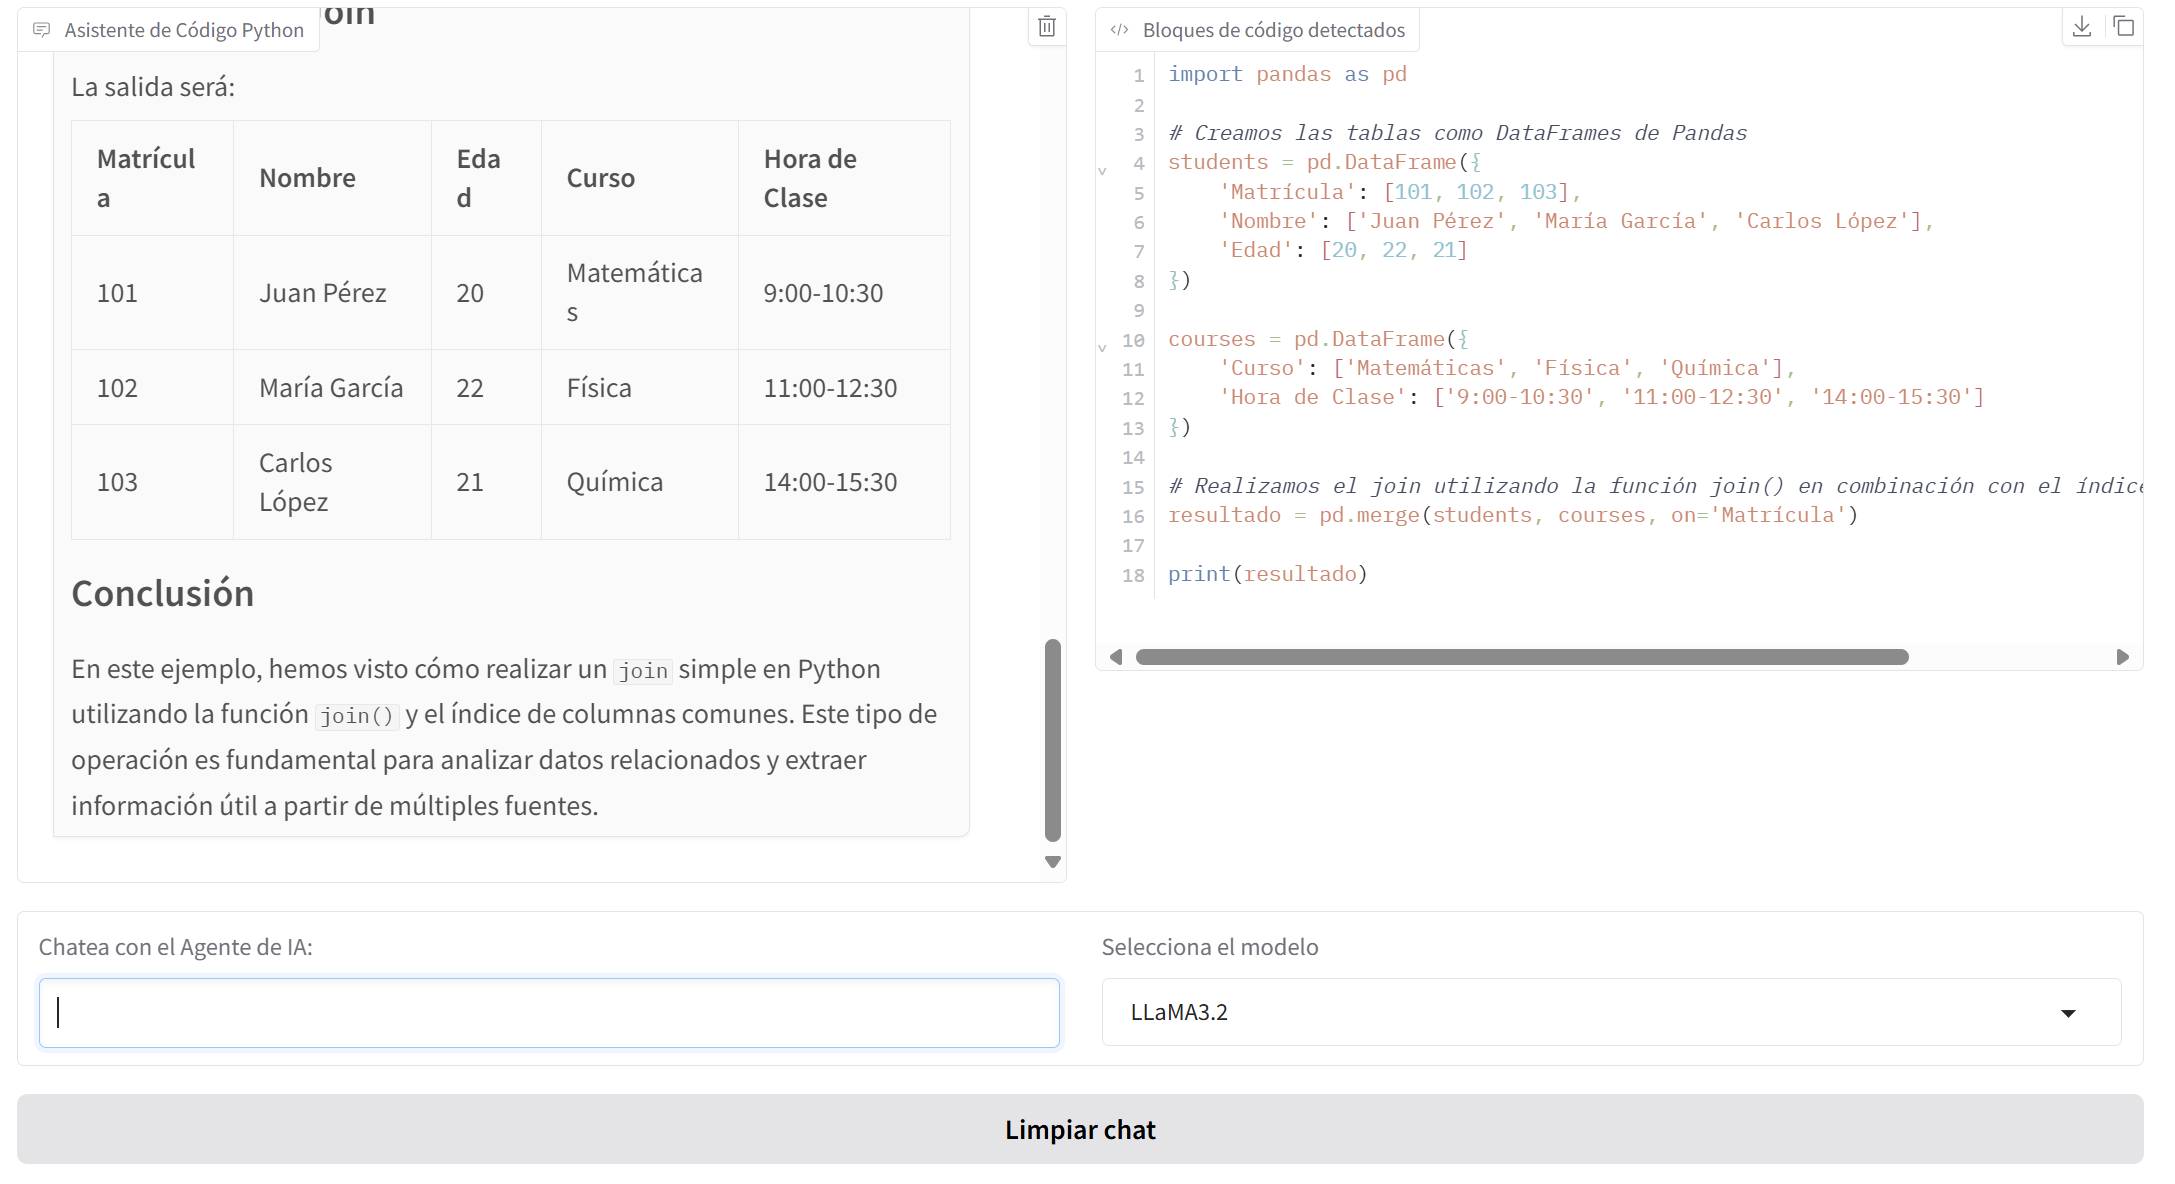

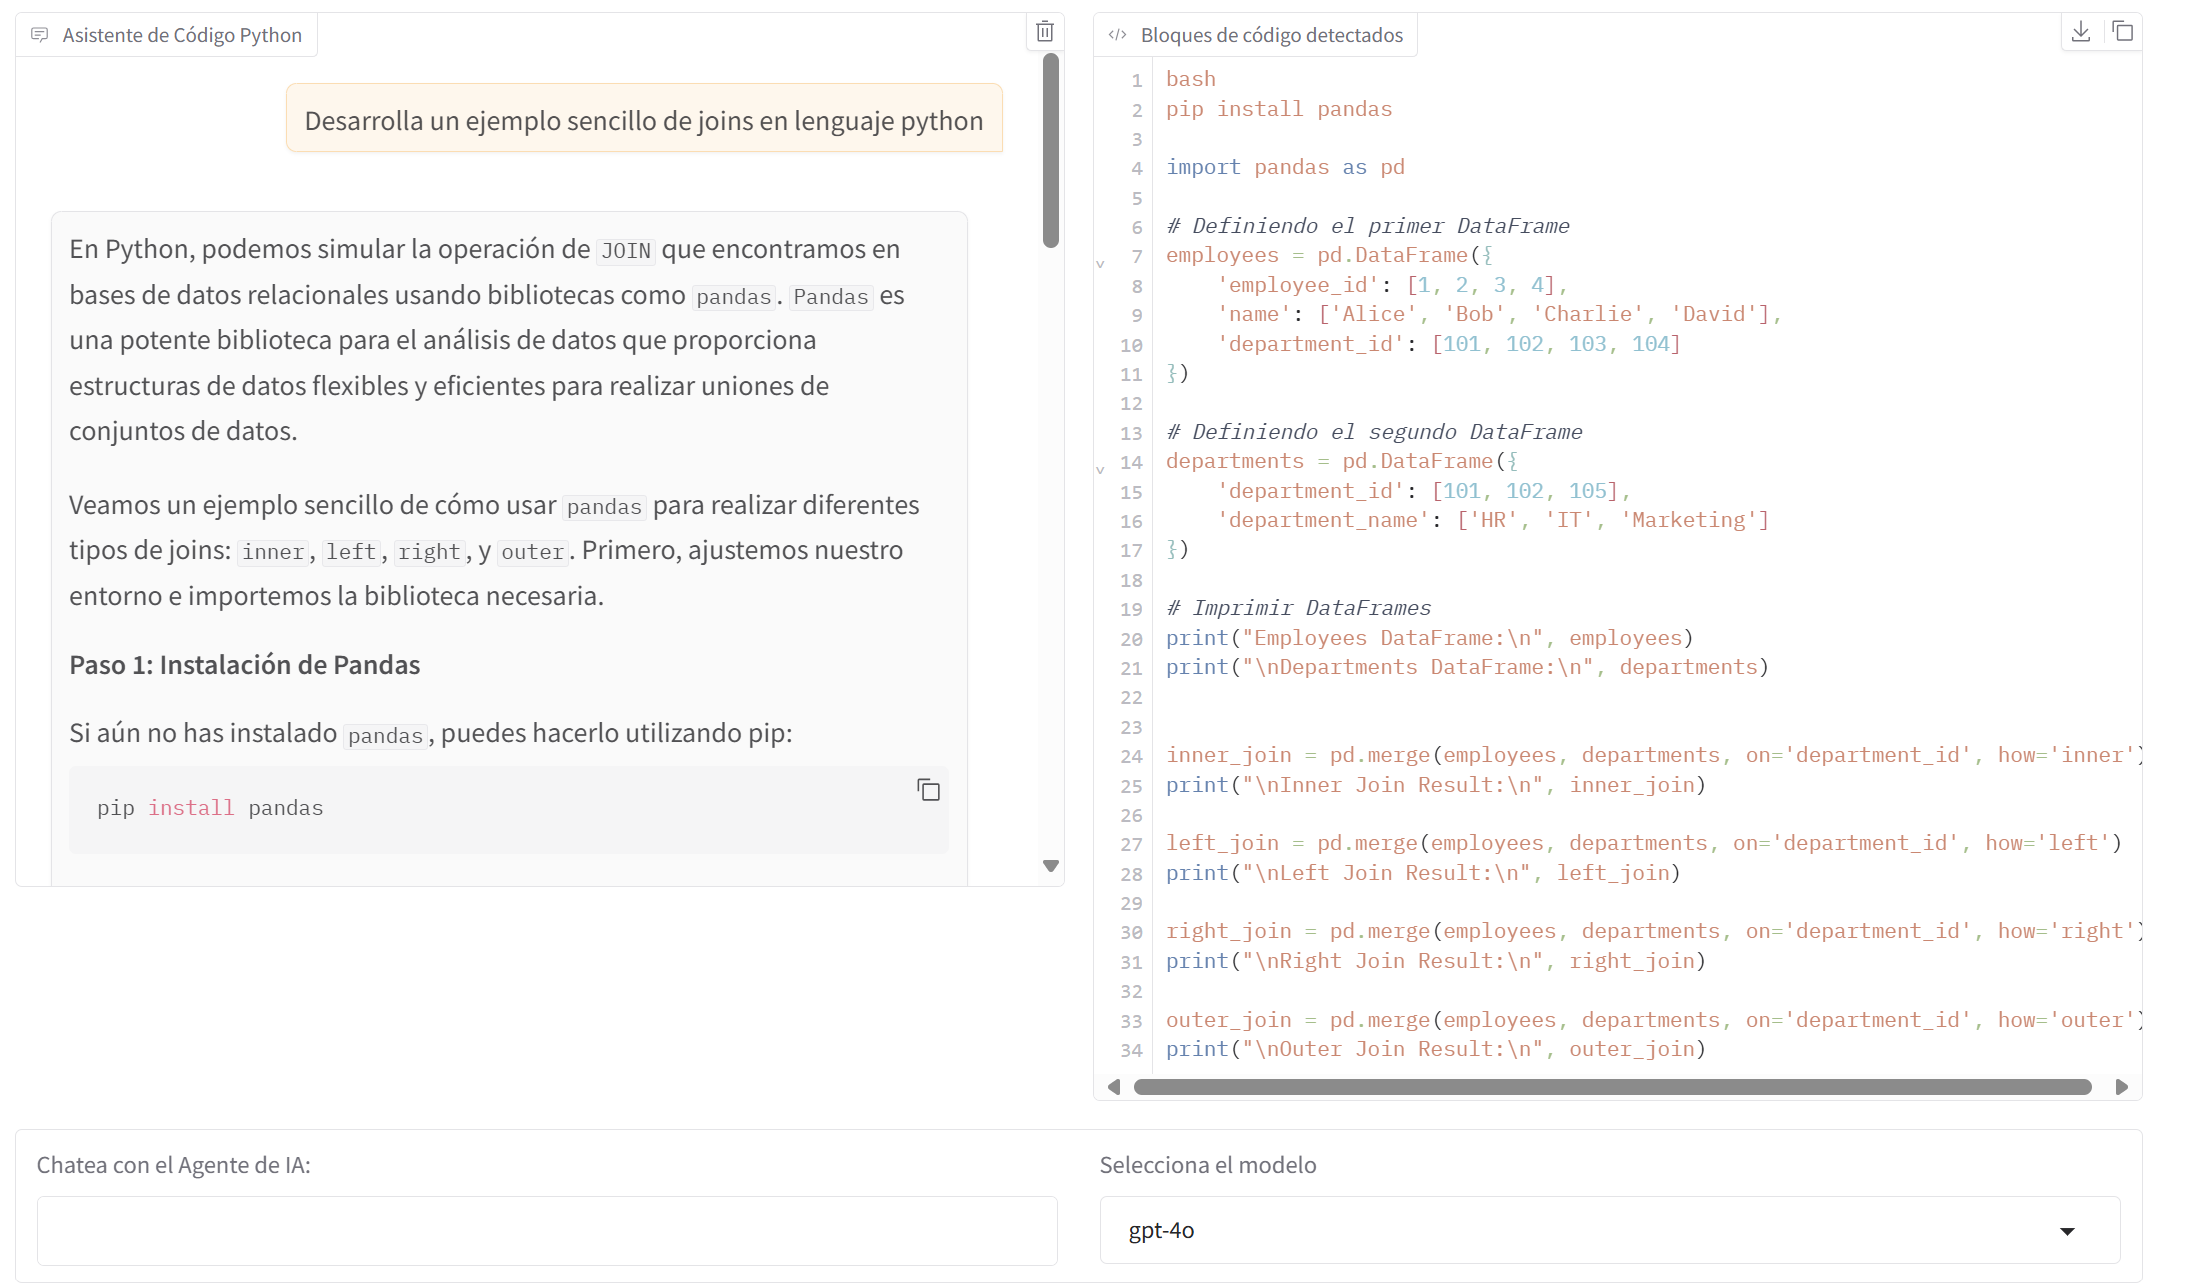